# Assingment Four - Practicing Data Science

## 1: Region and Domain
The region I have selected for this assignment is the United Kingdom. The domain I have selected is housing and house prices.

## 2: Research Question
How have house prices and house rental prices changed across the United Kingdom over the from 2011 to 2017?

## 3: Data Links
Average private rents:
https://files.datapress.com/london/dataset/average-private-rents-borough/2018-04-04T11:23:31.79/voa-average-rent-borough.xls
UK house pricing index:
https://files.datapress.com/london/dataset/uk-house-price-index/2018-03-21T11:01:51.23/UK%20House%20price%20index-v2.xls

In [19]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load data 
average_rent_df = pd.read_excel('https://files.datapress.com/london/dataset/average-private-rents-borough/2018-04-04T11:23:31.79/voa-average-rent-borough.xls',
                                sheet_name='Regions raw data', skiprows=2, usecols=[0,1,2,3,5])
house_prices_df = pd.read_excel('https://files.datapress.com/london/dataset/uk-house-price-index/2018-03-21T11:01:51.23/UK%20House%20price%20index-v2.xls',
                                sheet_name='Average price', usecols='A, AM:AU').dropna().reset_index()

# Rename columns/region data for joining later, filter for average rents
average_rent_df['Region'] = average_rent_df['Region'].str.upper()
average_rent_df = average_rent_df.where(average_rent_df['Category'] == 'All categories').dropna()
average_rent_df['Year'] = average_rent_df['Year'].astype(int)

average_rent_df.rename(columns={'Average' : 'Average Monthly Rent'}, inplace=True)
average_rent_df.drop(['Category'], axis=1, inplace=True)
house_prices_df.rename(columns={'EAST OF ENGLAND': 'EAST', 'YORKS & THE HUMBER': 'YORKS & HUMBER'}, inplace=True)


In [3]:
# Get and set Q for house prices as index
house_prices_df['Q'] = pd.PeriodIndex(pd.to_datetime(house_prices_df['index']), freq='Q')
house_prices_df['Q'] = house_prices_df['Q'].astype('str')
house_prices_df = house_prices_df[house_prices_df['Q'].str.contains('Q3|Q1', regex=True)].dropna()
house_prices_df = house_prices_df.groupby(['Q'])['NORTH EAST', 'NORTH WEST', 'YORKS & HUMBER', 'EAST MIDLANDS', 'WEST MIDLANDS', 'EAST', 'SOUTH EAST', 'SOUTH WEST'].mean()
house_prices_df = house_prices_df.reset_index().melt('Q', var_name='Region', value_name='Average Sale Price')
house_prices_df = house_prices_df.set_index(['Region','Q']).sort_index()

# Concat year and Q for average rent and set as index
average_rent_df['Q'] = average_rent_df['Year'].map(str) + average_rent_df['Quarter']
average_rent_df['Q'] = average_rent_df['Q'].astype('str')
average_rent_df = average_rent_df.drop(['Year', 'Quarter'], axis=1).set_index(['Region','Q']).sort_index()

In [4]:
df = pd.merge(house_prices_df, average_rent_df, how='inner', left_index=True, right_index=True)
df.head(20)

Average Sale Price  Average Monthly Rent
Region        Q                                               
EAST          2011Q3       191737.434700                651.97
              2012Q1       190427.757800                659.00
              2012Q3       195800.892833                669.00
              2013Q1       194287.011867                677.00
              2013Q3       201832.447967                676.00
              2014Q1       207157.928200                690.00
              2014Q3       224075.579400                705.00
              2015Q1       229052.188600                727.00
              2015Q3       244548.981133                750.00
              2016Q1       256789.956533                786.00
              2016Q3       271641.885567                815.00
              2017Q1       276628.117333                835.00
              2017Q3       288748.531167                846.00
EAST MIDLANDS 2011Q3       139867.755400                510.24
              2012Q1       136498.905300                521.00
              2012Q3       140012.644067                526.00
              2013Q1       137899.222233                527.00
              2013Q3       143372.334633                530.00
              2014Q1       146150.140867                537.00
              2014Q3       154318.056833                542.00

In [14]:
# Calculate percentage change for Sale prices and Monthy rents
df['sale_p_change'] = df['Average Sale Price'].pct_change()
df['rent_p_change'] = df['Average Monthly Rent'].pct_change()
df.head()

Average Sale Price  Average Monthly Rent  sale_p_change  \
Region Q                                                                 
EAST   2012Q1       190427.757800                 659.0            NaN   
       2012Q3       195800.892833                 669.0       0.028216   
       2013Q1       194287.011867                 677.0      -0.007732   
       2013Q3       201832.447967                 676.0       0.038837   
       2014Q1       207157.928200                 690.0       0.026386   

               rent_p_change  
Region Q                      
EAST   2012Q1            NaN  
       2012Q3       0.015175  
       2013Q1       0.011958  
       2013Q3      -0.001477  
       2014Q1       0.020710

In [20]:
df1 = df.copy()
df1 = df1.reset_index(level='Region')
uk_averages = df1.groupby(df1.index).mean()
uk_averages['min_rent'] = df1['Average Monthly Rent'].groupby(df1.index).min()
uk_averages['max_rent'] = df1['Average Monthly Rent'].groupby(df1.index).max()
uk_averages['min_sale'] = df1['Average Sale Price'].groupby(df1.index).min()
uk_averages['max_sale'] = df1['Average Sale Price'].groupby(df1.index).max()
# Hard set first %age chage as 0 as NaN due to incomplete data (see above df.head())
uk_averages['sale_p_change'][0] = np.NaN
uk_averages['rent_p_change'][0] = np.NaN
uk_averages.head()

,Average Sale Price,Average Monthly Rent,sale_p_change,rent_p_change,min_rent,max_rent,min_sale,max_sale
Q,,,,,,,,
2011Q3,154044.432814,572.982857,NaN,NaN,477.69,815.26,117270.684100,221196.245767
2012Q1,156033.126421,591.625000,-0.020366,0.015923,468.00,823.00,114495.012600,218413.619933
2012Q3,160313.865100,596.500000,0.026906,0.008198,471.00,829.00,118360.026600,227695.694867
2013Q1,157401.233512,603.000000,-0.019986,0.009987,477.00,849.00,113584.876667,224788.609433
2013Q3,163652.101417,605.125000,0.039947,0.002674,479.00,857.00,119307.968300,234467.108700


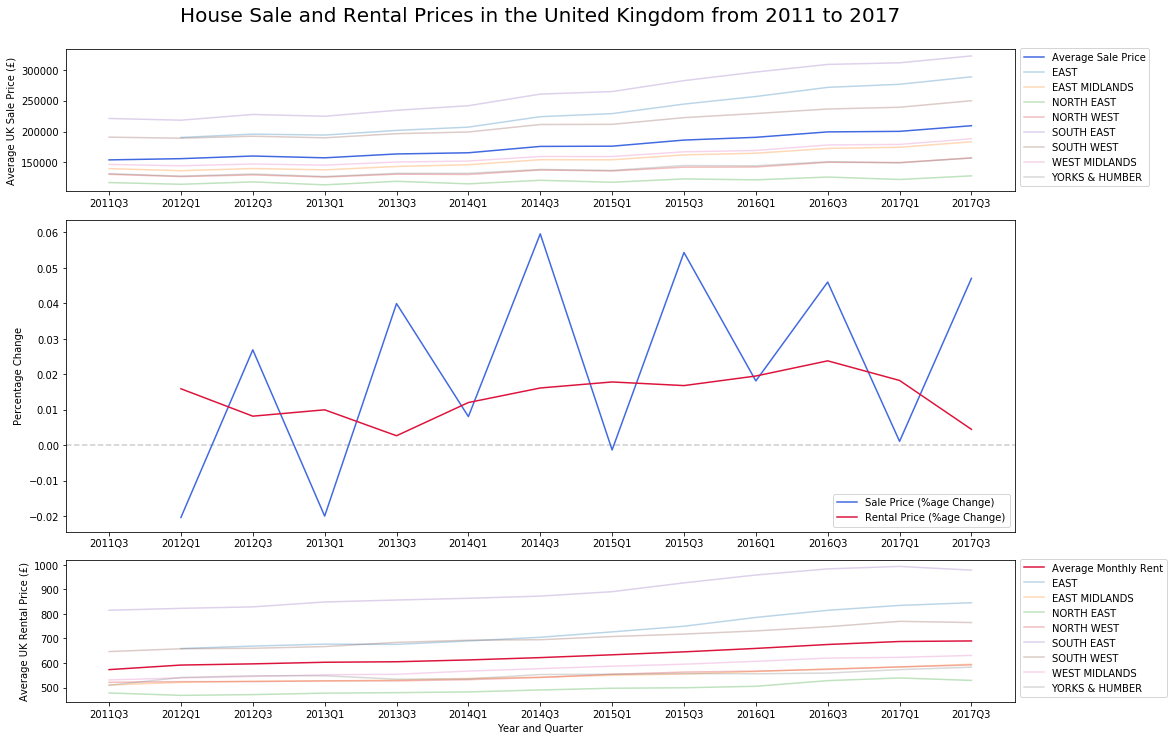

In [23]:
plt.figure(figsize=(17, 12))

# Average Sale Prices
plt.subplot2grid((4, 1), (0, 0), rowspan=1, colspan=1)

plt.plot(uk_averages.index.values, uk_averages['Average Sale Price'], color='royalblue')
for i in df1['Region'].unique():
    plt.plot(df1['Average Sale Price'].where(df1['Region'] == i), alpha=0.3, label=i)
plt.gca().set_ylabel('Average UK Sale Price (£)')
plt.title('House Sale and Rental Prices in the United Kingdom from 2011 to 2017\n', size=20)
plt.legend(loc=3, bbox_to_anchor=(1, 0))

# Percentage Change
plt.subplot2grid((4, 1), (1, 0), rowspan=2, colspan=1)
plt.axhline(y=0.00, color='black', alpha=0.2, linestyle='--')
plt.plot(uk_averages.index.values, uk_averages['sale_p_change'], label='Sale Price (%age Change)', color='royalblue')
plt.plot(uk_averages.index.values, uk_averages['rent_p_change'], label='Rental Price (%age Change)', color='crimson')
plt.legend(loc='lower right')

plt.gca().set_ylabel('Percentage Change')

# Average Rental Prices
plt.subplot2grid((4, 1), (3, 0), rowspan=1, colspan=1)
plt.plot(uk_averages.index.values, uk_averages['Average Monthly Rent'], color='crimson')
for i in df1['Region'].unique():
    plt.plot(df1['Average Monthly Rent'].where(df1['Region'] == i), alpha=0.3, label=i)
plt.gca().set_ylabel('Average UK Rental Price (£)')
plt.gca().set_xlabel('Year and Quarter')
plt.legend(loc=3, bbox_to_anchor=(1, 0))
